### 羅然莉 (Shallow Machine Learning | CNN Yale)
---------------------------------------------------------------------------------------

**| 目的 |**  

- 利用 PyTorch 深度機器學習 CNN 模型進行 Yale Face 人臉辨識。


**| 資料來源 |**  
- Yale.xlsx
- 38 個不同的人、圖片為 168*192 pixel (32256)、每人約 60 張左右圖片、共有 2410 張

**| 作業 |**  

- 寫一段程式實際對已訓練完成的 CNN 模型（讀入 pre-trained pth 檔）輸入任何一張測試影像，並列印出所辨識的人臉 Label。

---------------------------------------------------------------------------------------

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import pandas as pd

---------------------------------------------------------------------------------------


## **<font color=#4169e1>Load data and prepare for Torch</font>**

- 要跑 Pytorch CNN 模型，須先將資料轉換成 tensors 資料型態
- 下方程式碼主要為資料準備，包含讀取資料、切成訓練測試資料、轉換成 tensor 資料型態等

In [55]:
# Read Data
D = scipy.io.loadmat('data/allFaces.mat')

In [56]:
X = D['faces'].T # 32256*2410 each column represents an image 

n_persons = int(D['person']) # 38個人
m = int(D['m']) # 168
n = int(D['n']) # 192

N = np.ndarray.flatten(D['nfaces']) # 分別代表每個人的張數
Each_Num = N.tolist()
y = np.repeat(np.arange(38), Each_Num)

In [57]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size) # deafult test_size=0.25
 
# standaredize (may not be necessary)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# reshape to fit CNN 
X_train = X_train.reshape(-1, 1, 168, 192)  # Convert to N x 1（黑白） x 168 x 192 for CNN
X_test = X_test.reshape(-1, 1, 168, 192)  # N x 1 x 168 x 192
X_train = np.transpose(X_train,(0, 1, 3, 2))  # Convert to N x 1（黑白） x 168 x 192 for CNN
X_test = np.transpose(X_test,(0, 1, 3, 2)) 

# Convert to tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()

# Check shapes of the data
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

# Create dataloaders (以方便進行數據的分批次處理和隨機順序洗牌)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X_train.shape: torch.Size([1928, 1, 192, 168])
y_train.shape: torch.Size([1928])
X_test.shape: torch.Size([482, 1, 192, 168])
y_test.shape: torch.Size([482])


<font color=#f4a460>筆記：.float() 與 .long() </font>

在深度學習中，特徵數據和標籤數據通常需要以不同的數據類型表示。

- 特徵數據（Features）：特徵數據是用於描述樣本的數據，例如圖像的像素值、文字的向量表示等。在深度學習中，通常將特徵數據表示為浮點數（float）類型，常見的有32位浮點數（float32）或64位浮點數（float64）。浮點數能夠表示小數和大數，並提供了足夠的精度以捕捉數據的細節和變化。

- 標籤數據（Labels）：標籤數據是用於表示樣本的目標值或類別標籤的數據，例如圖像的分類標籤、文字的情感標籤等。在深度學習中，標籤數據通常表示為整數（integer）類型，具體來說是長整型（long），用於標識不同的類別或目標值。

區分特徵數據和標籤數據的數據類型是為了區分模型的輸入和輸出。在模型訓練過程中，特徵數據被用於餵入模型進行預測，而標籤數據則用於計算損失函數，衡量模型的預測結果與真實值之間的差異。

---------------------------------------------------------------------------------------

## **<font color=#4169e1>Set up NN Model </font>**

- 下方程式主要在建立 CNN model 
- 共設有 3 個捲基層（需固定的參數曾包含輸入 1 及最後的輸出 38）
- 並加入 batch_norm 來標準化，以提升模型的學習效率 （來自羅亦淳同學的建議）
- 為了避免層數錯誤，導致模型出錯，特別在 Confirm the structure of the data 的地方，查看每一層的結構（程式碼來自汪群超老師）

In [58]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, padding=1)  # 1 input channel（黑白）, 6 output channels, 3x3 square convolution（kernal size), padding
        self.batch_norm1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 24 , 3, padding=1)  # 6 input channel, 24 output channels, 3x3 square convolution（kernal size), padding
        self.batch_norm2 = nn.BatchNorm2d(24)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(48384 , 128)  
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 38) # 38 output classes
   
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))  # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) 
        x = torch.flatten(x, 1)  # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

net = Net().to(device)
print(net)


Using cpu device
Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=48384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=38, bias=True)
)


<font color=#f4a460>筆記：參數調整</font>        

要調整上述程式碼中的參數，可以從以下方面進行調整：

- 卷積層（Convolutional layers）：可以調整卷積層的輸入通道數（input channels）、輸出通道數（output channels）、卷積核尺寸（kernel size）和填充（padding）。這些參數可以根據任務和數據集的特點進行調整，以提取更有效的特徵。

- 線性層（Linear layers）：可以調整線性層的輸入和輸出維度。這些參數的設置通常與數據的形狀和模型的架構相關，需要根據具體的任務和需求進行調整。

- 激活函數（Activation functions）：在模型的forward函數中使用了ReLU激活函數，可以考慮嘗試其他激活函數，例如Sigmoid或Tanh，看是否對模型的性能有所改善。

- 訓練參數（Training parameters）：這裡的程式碼中沒有展示訓練過程的細節，但是可以調整訓練的超參數，例如學習率、批次大小、訓練迭代次數等，以優化模型的訓練過程。

<font color=#f4a460>筆記：Batch Normalization</font>    
Batch Normalization 的主要目的是對神經網絡的中間層的輸出進行標準化處理，使其在訓練過程中保持輸出的均值接近 0，方差接近 1。這樣做可以幫助模型更好地處理激活函數的輸入，防止梯度消失或爆炸，並提高模型的學習速度和效果。

## **<font color=#4169e1>Confirm the structure of the data </font>**

In [3]:
input = torch.randn(128, 1, 192, 168) # 20 random 28*28  images

# layer 1
m = nn.Conv2d(1,6,3, stride=1, padding=1)
output = m(input)
print(output.shape)
output = F.max_pool2d(F.relu(output),(2,2))
print(output.shape)

# layer 2
m = nn.Conv2d(6,24,3, stride=1, padding=1)
output = m(output)
print(output.shape)
output = F.max_pool2d(F.relu(output),2)
print(output.shape)

output = torch.flatten(output,1)
# output.view(-1, 32*19*6)
print(output.shape)

m = nn.Linear(48384, 128)
output = m(output)
print(output.shape)

m = nn.Linear(128, 64)
output = m(output)
print(output.shape)

m = nn.Linear(64, 38)
output = m(output)
print(output.shape)

torch.Size([128, 6, 192, 168])
torch.Size([128, 6, 96, 84])
torch.Size([128, 24, 96, 84])
torch.Size([128, 24, 48, 42])
torch.Size([128, 48384])
torch.Size([128, 128])
torch.Size([128, 64])
torch.Size([128, 38])


In [60]:
# TO check how many parameters

def print_num_parameters(model, name="Net"):
    print("Number of parameters in %s" % name,
        sum(p.numel() for p in model.parameters()))

print_num_parameters(Net(), "the CNN")

Number of parameters in the CNN 6205434


---------------------------------------------------------------------------------------

## **<font color=#4169e1>Observe the image and network</font>**

這段程式碼的目的是顯示圖像的視覺化結果，並檢視神經網路模型對單個圖像的預測結果

(1, 38)
tensor([[-0.0613,  0.0200, -0.0260, -0.1167,  0.0382,  0.0443, -0.0351,  0.0758,
          0.1295,  0.0808, -0.0898,  0.0276,  0.0619,  0.0287, -0.0722, -0.0091,
         -0.0753,  0.0298, -0.0490, -0.0274,  0.0504, -0.0645,  0.1804,  0.0120,
          0.1418,  0.0711, -0.0386, -0.0304,  0.1093, -0.1388,  0.0243, -0.0696,
         -0.0002,  0.0646,  0.0633,  0.0423,  0.1309,  0.1135]])
tensor([[22]])
[[-0.06133182  0.01995555 -0.02603182 -0.11672317  0.03819409  0.0443425
  -0.03508221  0.07579704  0.12949425  0.08081589 -0.08981596  0.02761948
   0.06187009  0.02868327 -0.07219147 -0.00907978 -0.07529072  0.02984501
  -0.04904404 -0.02740812  0.05042566 -0.06449766  0.18035036  0.01199224
   0.14181575  0.07108618 -0.03862478 -0.03043883  0.10931466 -0.1388196
   0.02429007 -0.06961692 -0.00019453  0.06460647  0.06329202  0.04225561
   0.13090473  0.11353949]]
torch.Size([128, 1, 192, 168])


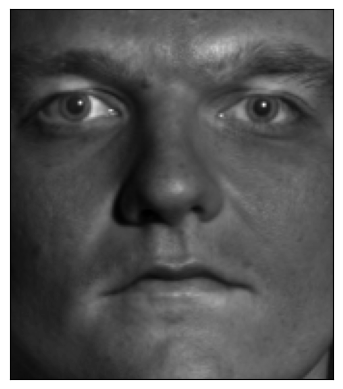

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


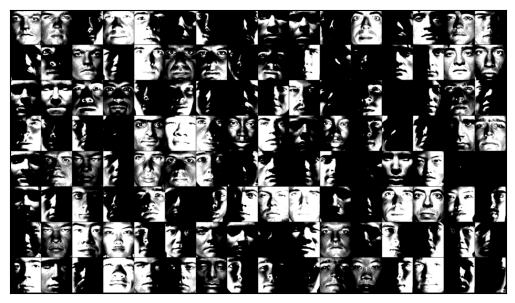

In [61]:
input = train_dataset[0][0].reshape(1, 1, 192, 168) # train_dataset: torch.Size([1, 192, 168])

# 觀察 network 輸出結果
out = net(input.to(device))
print(out.to("cpu").detach().numpy().shape)
print(out.data)  # 取預測結果的數據部分
print(out.data.max(1, keepdim=True)[1])
print(out.to("cpu").detach().numpy())
 
# get some random training images
dataiter = iter(train_loader) # an iterable object (從可迭代對象中獲取下一個批次的圖像和標籤)
images, labels = next(dataiter) # get the next batch
print(images.shape) # print 圖像的形狀，這裡假設圖像是一批次的多個單通道圖像
 
# show a single image
a_image = images[0]
a_image_ = np.transpose(a_image, (1, 2, 0)) # 將圖像的維度重新排列，使得通道維度（在這種情況下是單通道）位於最後一個位置
plt.imshow(a_image_, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()
 
# show a grid of images
montage = torchvision.utils.make_grid(images, nrow=16) # make a grid of images with 16 images per row
plt.imshow(np.transpose(montage, (1, 2, 0)), cmap='gray') # 將圖像的維度重新排列，使得通道維度（在這種情況下是單通道）位於最後一個位置
plt.xticks([])
plt.yticks([])
plt.show()

<font color=#f4a460>筆記：train_dataset[0][0]</font>   
- train_dataset[0][0] 的意思是從訓練資料集中取得索引為 0 的樣本的 input 部分。

- 因為資料集中的每個樣本是以 (input, label) 的形式存儲的，所以 train_dataset[0] 返回的是索引為 0 的樣本，即 (input, label)。接下來，train_dataset[0][0] 表示從索引為 0 的樣本中取得 input 部分。因此，這個表達式獲得了資料集中索引為 0 的樣本的 input。

<font color=#f4a460>筆記：detach()</font>        

在 PyTorch 中，計算圖是由張量（Tensors）和操作（Operations）組成的圖形結構，用於記錄計算過程和梯度的傳播。當你對一個張量進行操作時，PyTorch會自動構建計算圖並跟踪該操作的梯度計算。

使用detach()方法可以從計算圖中分離（detach）一個張量，創建一個新的張量，這個新張量不再與原始計算圖相關聯。換句話說，該操作將使得新的張量不再保留原始張量的梯度歷史。

這在某些情況下是很有用的，特別是當你只對某些部分進行計算，而不需要計算梯度時。通常，當你想要在計算圖中斷開梯度的反向傳播時，你可以使用detach()方法。

例如，在上述程式碼中，out 是通過將 input 傳遞給 net 模型獲得的輸出。當我們使用 out.backward() 計算梯度時，由於 out 是通過對 input 進行操作得到的，計算圖會保留這個操作的梯度計算。然而，有時我們只需要獲得 out 的值，而不需要計算梯度。這時，我們可以使用 detach() 方法將 out 從計算圖中分離出來，創建一個不保留梯度歷史的新張量。

總而言之，detach() 方法用於從計算圖中分離張量，創建一個新的不保留梯度的張量。這在某些情況下可以提高效率或避免不需要的梯度計算。

<font color=#f4a460>筆記：其他</font>  
- out = net(input.to(device))：將調整後的輸入特徵 input 傳遞給網絡模型 net，並在指定的設備上執行計算。模型將輸入特徵進行前向傳播計算，獲得預測結果 out。
- print(out.data.max(1, keepdim=True)[1])：計算預測結果中每個樣本的最大值索引，並打印結果。out.data.max(1, keepdim=True)對預測結果的每一行進行最大值計算，[1]選取最大值的索引。

---------------------------------------------------------------------------------------

## **<font color=#4169e1>Define a Loss function and optimizer</font>**

下方程式碼用於定義損失函數和優化器，用於訓練神經網路模型

In [62]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
# optimizer = optim.Adam(net2.parameters(), lr = 0.01) 

<font color=#f4a460>筆記：上述程式碼說明</font>        

- criterion = nn.CrossEntropyLoss(): 定義損失函數。在這裡使用的是交叉熵損失函數，它通常用於多類別分類問題。交叉熵損失函數計算模型的預測結果和實際標籤之間的差異。

- optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9): 定義優化器。在這裡使用的是隨機梯度下降（SGD）優化器，它用於根據損失函數的梯度來更新模型的參數。net.parameters() 用於獲取模型中需要更新的參數，lr=0.001 是學習率，控制每次更新的步伐大小，momentum=0.9 是動量參數，用於加速優化過程。

- optimizer = optim.Adam(net2.parameters(), lr = 0.01):  Adam 優化器是另一種常用的優化器算法，能夠更快地收斂和調整學習率。

這些設置和定義的損失函數以及優化器是用於訓練神經網路模型時進行參數更新和損失計算的重要元素。損失函數衡量模型的預測結果和實際標籤之間的差異，而優化器則根據損失函數的梯度調整模型的參數，以最小化損失並提升模型的預測能力。

---------------------------------------------------------------------------------------

## **<font color=#4169e1>Train the network</font>**

- epochs 設定為 30 來訓練
- 到第 30 個 epoch: loss 降為 0.001
- 訓練完後儲存以供未來測試使用

In [63]:
epochs = 30

for epoch in range(epochs):  # loop over the dataset multiple times
 
    running_loss = 0.0  # 初始化一個變數 running_loss，用於累積每個 epoch 中的損失值。
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device) # move to GPU if available
     
        # zero the parameter gradients
        optimizer.zero_grad()  # 將優化器的梯度歸零，以準備計算新的梯度
        # forward + backward + optimize
        outputs = net(inputs) # forward pass
        loss = criterion(outputs, labels) # compute loss
        # writer.add_scalar("Loss/train", loss, epoch)
        loss.backward() # compute gradients
        optimizer.step() # update weights
 
        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 200 mini-batches (每經過200個小批次（一小部分資料），執行以下操作)
            print(f'[epoch : {epoch + 1}, batch: {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0
 
print('Finished Training')

[epoch : 1, batch:    10] loss: 0.182
[epoch : 2, batch:    10] loss: 0.181
[epoch : 3, batch:    10] loss: 0.178
[epoch : 4, batch:    10] loss: 0.160
[epoch : 5, batch:    10] loss: 0.123
[epoch : 6, batch:    10] loss: 0.122
[epoch : 7, batch:    10] loss: 0.077
[epoch : 8, batch:    10] loss: 0.045
[epoch : 9, batch:    10] loss: 0.069
[epoch : 10, batch:    10] loss: 0.041
[epoch : 11, batch:    10] loss: 0.038
[epoch : 12, batch:    10] loss: 0.025
[epoch : 13, batch:    10] loss: 0.019
[epoch : 14, batch:    10] loss: 0.011
[epoch : 15, batch:    10] loss: 0.009
[epoch : 16, batch:    10] loss: 0.006
[epoch : 17, batch:    10] loss: 0.006
[epoch : 18, batch:    10] loss: 0.005
[epoch : 19, batch:    10] loss: 0.005
[epoch : 20, batch:    10] loss: 0.005
[epoch : 21, batch:    10] loss: 0.004
[epoch : 22, batch:    10] loss: 0.006
[epoch : 23, batch:    10] loss: 0.007
[epoch : 24, batch:    10] loss: 0.005
[epoch : 25, batch:    10] loss: 0.003
[epoch : 26, batch:    10] loss: 0

## **<font color=#4169e1>Save the trained model for later use</font>**

In [69]:
PATH = './cnn_yale_classification.pt' # .pth will collide with the PyTorch JIT
torch.save(net.state_dict(), PATH)

---------------------------------------------------------------------------------------

## **<font color=#4169e1>Test the network on the test data</font>**

下方進行測試：
- 整體預測準確率 91%
- Batch 則為 89%

In [67]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad(): 
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
 
print(f'Accuracy of the network on the Yale test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 91 %


## **<font color=#4169e1>Test on a random batch</font>**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


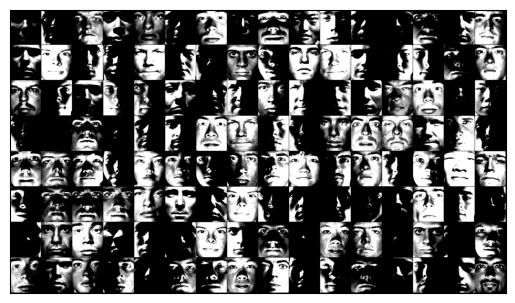

The predictions:
 {tensor([[ 4,  3,  6, 31, 16, 24, 34, 20, 34, 25, 34,  0, 18, 31, 21, 37],
        [24, 14, 23, 20,  2,  6, 28, 29, 26, 24,  2, 37, 25, 21, 28, 22],
        [19, 14, 37, 29,  7, 13,  3,  2, 11,  2, 34, 23, 36, 34, 21, 35],
        [18, 12, 24, 30,  3,  8,  1,  2,  0, 12, 23,  5,  0,  2, 23, 27],
        [32, 28,  4, 26, 25, 30, 30, 11, 24,  4,  8, 22, 21, 26, 12, 17],
        [34, 18, 31, 31, 16,  9, 13, 14,  8, 15,  7, 20,  9, 27, 37,  2],
        [23,  7, 34, 12, 34,  2, 14, 29, 29,  2, 35, 28, 32, 29, 25, 26],
        [34, 18, 22, 11, 33, 28,  1, 35,  5, 20,  2, 28, 10,  0, 29,  8]])}
Accuracy of the network on the 64 test images: 89.0625 %


In [68]:
sample_idx = torch.randint(len(test_loader), size=(1,)).item()
dataiter = iter(test_loader)
for i in range(sample_idx): # randomly select a batch
    images, labels = next(dataiter)
 
# print test images
nrow = 16 # number of images per row
montage = torchvision.utils.make_grid(images, nrow=nrow)
plt.imshow(np.transpose(montage, (1, 2, 0)), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()
 
# predict the labels
outputs = net(images.to(device)) # 將圖像輸入 NET 模型，進行預測
_, predicted = torch.max(outputs, 1)
print("The predictions:\n", {predicted.reshape(batch_size // nrow, nrow)})
 
total = labels.size(0)
correct_rate = (predicted == labels.to(device)).sum().item() / total
print(f'Accuracy of the network on the batch test images: {100 * correct_rate} %')

---------------------------------------------------------------------------------------

## **<font color=#4169e1>Predict the Image</font>**

- 將訓練好的模型讀入並用於預測
- 結果顯示其準確預測了人臉

In [70]:
model = Net()
model.load_state_dict(torch.load('./cnn_yale_classification.pt'))
model.eval()

with torch.no_grad():
    #output  = model(images[0:1,:,:,:])
    output  = model(X_test[-1:,:,:,:])
    t, predicted_idx = torch.max(output.data, 1)

print(predicted_idx)
print(y_test[-1])

tensor([23])
tensor(23)
